In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit as scipy_curve_fit
from scipy.stats import poisson

from emely import curve_fit as emely_curve_fit

In [2]:
# define plot style
violet = "#785ef0"
blue = "#648fff"
yellow = "#ffb000"
orange = "#fe6100"
red = "#dc267f"
black = "000000"
gray = "cccccc"
white = "ffffff"

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.dpi"] = 300

The goal is to estimate the parameters $a$, $\mu$, $\sigma_0$, $D$, and $\tau$ of a normalized and decaying Gaussian function:

$
f(x, t) = \frac{a}{\sqrt{2\pi\,\sigma^2}\cdot \tau} \, e^{-\frac{(x - \mu)^2}{2\sigma^2}} \cdot e^{-\frac{t}{\tau}}
$

with

$
\sigma^2 = \sigma_0^2 + 2Dt
$

from measurements

$
y(x, t) = f(x, t) + \varepsilon
$

where the noise term $ \varepsilon $ follows **Poisson statistics**. 

This setup represents, for example, an experiment aiming to determine the center and width of a Gaussian point-spread function (PSF) from photon-counting data. Here, the total number of detected photons would be $a = N_\mathrm{ph} \cdot \Delta x \cdot \Delta t$, where $\Delta x$ and $\Delta t$ are the sampling periods.

In these scenarios, least-squares optimization is not optimal because it assumes that the noise follows Gaussian statistics.  
Instead, it is more appropriate to use **maximum likelihood estimation (MLE)** formulated for **Poisson noise**. This becomes particularly relevant if the number of detected photons is low.

Here, we demonstrate how the Emely package can be used to perform parameter estimation using MLE.

In [3]:
# define the model to fit
def decaying_gaussian(x, t, a, mu, sigma_0, D, tau):
    sigma = np.sqrt(sigma_0**2 + 2 * D * t)

    return (
        a
        / np.sqrt(2 * np.pi * sigma**2)
        / tau
        * np.exp(-((x - mu) ** 2) / (2 * sigma**2))
        * np.exp(-t / tau)
    )

In [4]:
# define estimators
estimators = {
    "Least-Squares": lambda f,
    xdata,
    ydata,
    p0,
    bounds,
    sigma,
    absolute_sigma: scipy_curve_fit(
        f,
        xdata,
        ydata,
        p0=p0,
        bounds=bounds,
        sigma=sigma,
        absolute_sigma=absolute_sigma,
    ),
    "Gaussian-MLE": lambda f,
    xdata,
    ydata,
    p0,
    bounds,
    sigma,
    absolute_sigma: emely_curve_fit(
        f,
        xdata,
        ydata,
        p0=p0,
        bounds=bounds,
        sigma=sigma,
        absolute_sigma=absolute_sigma,
        noise="gaussian",
    ),
    "Poisson-MLE": lambda f,
    xdata,
    ydata,
    p0,
    bounds,
    sigma,
    absolute_sigma: emely_curve_fit(
        f,
        xdata,
        ydata,
        p0=p0,
        bounds=bounds,
        sigma=sigma,
        absolute_sigma=absolute_sigma,
        noise="poisson",
    ),
}

In [5]:
# define model parameters
dx = 160e-9  # (m)
dt = 200e-12  # (s)
mu = 0  # (m)
sigma_0 = 300e-9  # (m)
D = 1.4e-6  # (m^2/s)
tau = 1.2e-9  # (s)
N_ph = 1e4  # number of detected photons
p = (N_ph * dx * dt, mu, sigma_0, D, tau)

# define model variables
x_rng = (-3 * sigma_0, 3 * sigma_0)
n_x = round((x_rng[1] - x_rng[0]) / dx) + 1
x = x_rng[0] + dx * np.arange(n_x)

t_rng = (0, 3 * tau)
n_t = round((t_rng[1] - t_rng[0]) / dt) + 1
t = t_rng[0] + dt * np.arange(n_t)

x, t = np.meshgrid(x, t)

# set the random seed
np.random.seed(5)

In [ ]:
# create N measurements
f_x = decaying_gaussian(x, t, *p)
N = 200

# parameter estimates
p_opt = {name: np.zeros((N, len(p))) for name in estimators}
p_cov = {name: np.zeros((N, len(p), len(p))) for name in estimators}

# reshape variables
u = np.array([x.flatten(), t.flatten()])

for ii in range(N):
    # add noise to measurement
    y_x = poisson.rvs(f_x)
    y_u = y_x.flatten()

    # define initial guesses
    p_0 = None

    # define bounds
    bounds = (
        [1e-15, -1e-6, 1e-8, 5e-7, 1e-8],
        [1e-10, 1e-6, 1e-6, 5e-6, 1e-7],
    )
    for name in estimators:
        try:
            p_opt[name][ii, :], p_cov[name][ii, :, :] = estimators[name](
                lambda u, a, mu, sigma_0, D, tau: decaying_gaussian(
                    *u, a, mu, sigma_0, D, tau
                ),
                u,
                y_u,
                p0=p_0,
                bounds=bounds,
                sigma=1,
                absolute_sigma=False,
            )
        except RuntimeError:
            p_opt[name][ii, :] = np.nan * np.ones(len(p))
            p_cov[name][ii, :, :] = np.nan * np.ones((len(p), len(p)))

In [ ]:
# parameter settings
colors = [red, yellow, blue]
parameter_names = ["Amplitude", "Center", "Width", "Diffusivity", "Lifetime"]
parameter_units = ["", "(nm)", "(nm)", "(mm$^2$/s)", "(ns)"]
parameter_scaling = [1e12, 1e9, 1e9, 1e6, 1e9]

# parameter estimates
parameter_estimates = {
    parameter_name: pd.DataFrame({}, columns=estimators.keys())
    for parameter_name in parameter_names
}
for ii, parameter_name in enumerate(parameter_names):
    for estimator_name in estimators:
        parameter_estimates[parameter_name][estimator_name] = p_opt[estimator_name][
            :, ii
        ]

# empirical and estimated standard deviations
p_emp_std = {}
p_est_std = {}
for ii, parameter_name in enumerate(parameter_names):
    p_emp_std[parameter_name] = {}
    p_est_std[parameter_name] = {}
    for estimator_name in estimators:
        p_emp_std[parameter_name][estimator_name] = np.sqrt(
            np.var(p_opt[estimator_name][:, ii], axis=0)
        )
        p_est_std[parameter_name][estimator_name] = np.sqrt(
            np.mean(p_cov[estimator_name][:, ii, ii], axis=0)
        )

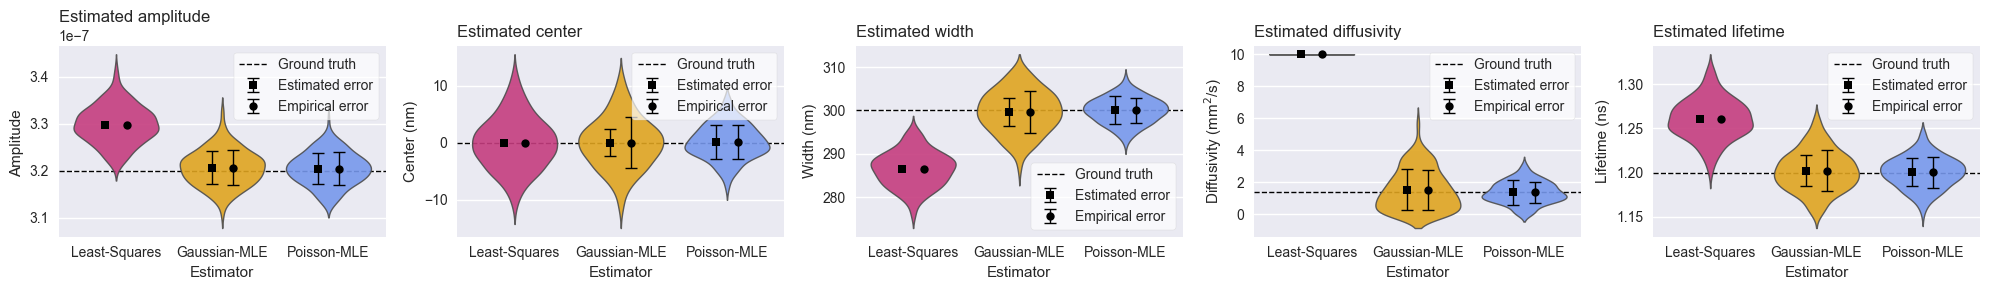

In [ ]:
fig, axs = plt.subplots(1, len(p), figsize=(4 * len(p), 3))

for ii in range(len(p)):
    sns.violinplot(
        parameter_scaling[ii] * parameter_estimates[parameter_names[ii]],
        inner=None,
        palette=colors,
        linewidth=1,
        alpha=0.9,
        ax=axs[ii],
        zorder=10,
    )

    offset = 0.1
    location = np.arange(len(estimators))
    y = [
        parameter_scaling[ii]
        * parameter_estimates[parameter_names[ii]][estimator_name].mean()
        for estimator_name in estimators
    ]

    # estimated standard deviation
    yerr = [
        parameter_scaling[ii] * p_est_std[parameter_names[ii]][estimator_name]
        for estimator_name in estimators
    ]
    axs[ii].errorbar(
        location - offset,
        y,
        yerr=yerr,
        color=black,
        linewidth=1,
        fmt="s",
        markersize=6,
        capthick=1,
        capsize=4,
        label="Estimated error",
        zorder=15,
    )

    # empirical standard deviation
    yerr = [
        parameter_scaling[ii] * p_emp_std[parameter_names[ii]][estimator_name]
        for estimator_name in estimators
    ]
    axs[ii].errorbar(
        location + offset,
        y,
        yerr=yerr,
        color=black,
        linewidth=1,
        fmt="o",
        markersize=6,
        capthick=1,
        capsize=4,
        label="Empirical error",
        zorder=15,
    )

    # ground truth
    axs[ii].axhline(
        parameter_scaling[ii] * p[ii],
        color=black,
        linestyle="--",
        linewidth=1,
        label="Ground truth",
        zorder=5,
    )

    axs[ii].set_title("Estimated " + parameter_names[ii].lower(), loc="left")
    axs[ii].set_xlabel("Estimator")
    axs[ii].set_ylabel(parameter_names[ii] + " " + parameter_units[ii])
    legend = axs[ii].legend(frameon=True, framealpha=0.7)
    legend.get_frame().set_facecolor("white")
    legend.set_zorder(20)

fig.tight_layout()